# Thematic differences (Ukraine)

DHH23 Parliament group

Author: Pontus H.

In [212]:
# Set the theme here
THEME = 'healthcare_UA'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [213]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [214]:
# Optional stopwords
with open('../data/stopwords-ua.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [215]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 10 # Lowered to 10 from 50
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  # nr_topics=10,
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [216]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-UA_2017-01-18-m0.u10,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фОпоблок,"Фракція політичної партії ""Опозиційний блок""",Opposition,"Валерійович Долженков, Олександр",M,1983.0,"Шановні колеги, шановні громадяни України! Тут...","Так, дійсно, ми не підтримуємо цю децентраліз...",-0.600586,5277
1,ParlaMint-UA_2017-01-18-m0.u71,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фЛяшко,Фракція Радикальної партії Олега Ляшка,Opposition,"Валерійович Ляшко, Олег",M,1972.0,"Олег Ляшко, Радикальна партія. Шановні колеги,...","Шановні колеги, звідки беруться бездомні, хто...",-1.000000,2579
2,ParlaMint-UA_2017-03-21-m1.u4,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-03-21,Unicameralism,8,6,NaN,2017-03-21,NaN,Reference,...,фОС,Фракція політичної партії «Об'єднання „Самопом...,Opposition,"Володимирівна Сисоєнко, Ірина",F,1982.0,У мене запитання до представника Міністерства ...,"Скажіть, будь ласка, в діючій редакції Закону...",-0.785156,680
3,ParlaMint-UA_2017-03-21-m1.u27,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-03-21,Unicameralism,8,6,NaN,2017-03-21,NaN,Reference,...,фОС,Фракція політичної партії «Об'єднання „Самопом...,Opposition,"Володимирівна Сисоєнко, Ірина",F,1982.0,"Фракція ""Об'єднання ""Самопоміч"" буде підтримув...",В нормах цього законопроекту є нові редакції ...,0.429199,2267
4,ParlaMint-UA_2017-03-21-m1.u33,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-03-21,Unicameralism,8,6,NaN,2017-03-21,NaN,Reference,...,фЛяшко,Фракція Радикальної партії Олега Ляшка,Opposition,"Валерійович Ляшко, Олег",M,1972.0,"Олег Ляшко, Радикальна партія. Мене взагалі ди...",Мене взагалі дивує реакція головуючої в парла...,-0.932617,4373


In [217]:
df['Speaker_party'].value_counts()

фВОБ        493
фЛяшко      396
фСН         374
фБПП        374
фОпоблок    314
фЄС         298
фОПЗЖ       290
фОС         287
фПГ         227
гДовіра     195
гЗМП        144
фНФ         132
гПВ          92
фСвобода     70
фУДАР        58
фПР          50
гЕР          50
гВН          36
гСЄУ         30
гЗМіС        12
гЗМ           8
НФ            7
Свобода       4
фБЮТ          2
np2           1
фКПУ          1
УСГ           1
Name: Speaker_party, dtype: int64

In [218]:
# Reference running time for this cell: 0min 30s
topics, probs = topic_model.fit_transform(df['speech'])


In [219]:
pd.Series(topics).value_counts()

-1     1911
 0       96
 1       95
 2       84
 3       84
       ... 
 89      10
 93      10
 91      10
 94      10
 90      10
Length: 97, dtype: int64

In [220]:
# Reduce outliers
# threshold reduced to 0.05 from 0.1
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)

In [221]:
pd.Series(new_topics).value_counts()

-1     221
 5     211
 2     199
 1     182
 0     152
      ... 
 94     13
 93     12
 90     12
 91     11
 88     11
Length: 97, dtype: int64

In [222]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [223]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [224]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 97
Number of topics before: 97


In [225]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     1911
 38      96
 37      95
 69      84
 67      84
       ... 
 64      10
 57      10
 41      10
 4       10
 34      10
Length: 97, dtype: int64

In [226]:
topic_model.visualize_topics()

In [227]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

In [228]:
# Get the most relevant speeches from a topic and save to a text file

def save_topic_speeches(topic_id):
    speeches = topic_model.get_representative_docs(topic_id)
    with open(f"{OUTPUT_PATH}{THEME}_topic{topic_id}_speeches.txt", "w", encoding="utf-8") as file:
        file.write(f"Relevant speeches for theme {THEME} and topic {topic_id}\n\n")
        for speech in speeches:
            file.write(speech)
            file.write("\n\n")
for topic_id in range(min(len(pd.Series(new_topics).unique()), 10)):
    save_topic_speeches(topic_id)

# Word Clouds

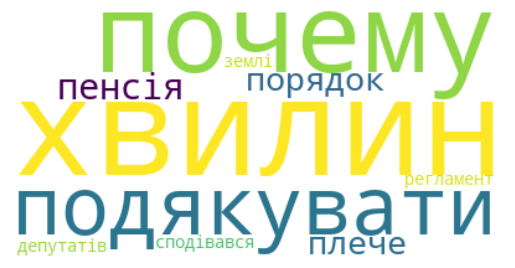

In [229]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [230]:
topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [231]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['хвилин',
 'почему',
 'подякувати',
 'пенсія',
 'порядок',
 'плече',
 'сподівався',
 'землі',
 'депутатів',
 'регламент']

In [232]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,72,20,34
1,115,25,33
2,86,29,35
3,55,25,29
4,56,12,20
5,118,25,33
6,43,17,6
7,49,12,12
8,32,20,6


In [233]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,10.4,10.3,16.0
1,16.5,12.8,15.6
2,12.4,14.9,16.5
3,7.9,12.8,13.7
4,8.1,6.2,9.4
5,17.0,12.8,15.6
6,6.2,8.7,2.8
7,7.1,6.2,5.7
8,4.6,10.3,2.8


In [234]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР,keywords
topic,,,,
0,10.4,10.3,16.0,"[хвилин, почему, подякувати, пенсія, порядок, ..."
1,16.5,12.8,15.6,"[коронавірусу, антитіла, моз, захворівших, тес..."
2,12.4,14.9,16.5,"[оплески, народження, справедливість, скасуван..."
3,7.9,12.8,13.7,"[pfizer, вакцинувати, міністре, брехня, 6297, ..."
4,8.1,6.2,9.4,"[піклування, типа, позбавлених, інтернати, сем..."
5,17.0,12.8,15.6,"[бюджету, мільярдів, зростання, державного, ен..."
6,6.2,8.7,2.8,"[савченко, надії, беркуту, поранених, незалежн..."
7,7.1,6.2,5.7,"[довгострокові, закупівлю, серцеві, лікарні, л..."
8,4.6,10.3,2.8,"[мозку, кісткового, трансплантацій, згоду, кро..."


In [235]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
0,0,57.1,15.9,27.0
1,1,66.5,14.5,19.1
2,2,57.3,19.3,23.3
3,3,50.5,22.9,26.6
4,4,63.6,13.6,22.7
5,5,67.0,14.2,18.8
6,6,65.2,25.8,9.1
7,7,67.1,16.4,16.4
8,8,55.2,34.5,10.3
9,9,83.1,12.0,4.8


Calculate mean sentiment for each topic per party

In [236]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,-0.57,-0.17,-0.73
1,-0.56,-0.73,-0.75
2,-0.41,-0.47,-0.57
3,-0.54,-0.74,-0.62
4,-0.41,-0.23,-0.58
5,-0.41,-0.65,-0.59
6,-0.71,-0.59,-0.52
7,-0.63,-0.69,-0.56
8,-0.13,-0.05,-0.80


In [237]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")